# 200 Mpc/h 

Here we download and analyse the simulations produced in a simulation box of 200 Mpc/h in each direction. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pickle, os
from glob import glob
from StoReS import * 
import tools21cm as t2c 
import toolscosmo
from tqdm import tqdm 

### N-body simulation with 200 Mpc/h in each direction

Cosmology of the simulation:

$\Omega_\mathrm{m} = 0.32$, $\Omega_\mathrm{b} = 0.044$, $h_\mathrm{0} = 0.67$, $\sigma_\mathrm{8} = 0.83$, $n_\mathrm{s} = 0.96$

Below we define a function calculating the growth factor, which will required later to compare linear power spectrum provided by a Boltzmann solver at redshift $z=0$.

In [2]:
par = toolscosmo.par()
par.cosmo.Om = 0.32
par.cosmo.Ob = 0.044
par.cosmo.s8 = 0.83 
par.cosmo.h0 = 0.67
par.cosmo.ns = 0.96

def D(z):
    Dz = toolscosmo.growth_factor(z, par)
    return Dz

We define the box length and the path to the folder for downloading the data.

In [3]:
box_len  = 200 #Mpc/h
save_dir = './work/'
eor_hist = {}

In [4]:
nby = GetData(name='pkdgrav3', work_dir=save_dir+'density/')

data_url = 'https://ttt.astro.su.se/~sgiri/data/200Mpc/CDM_200Mpc_2048'
psfile = get_file_info(data_url, 'CDM_200Mpc_2048_Plin', '.dat', verbose=False)[0]
print(f'Linear Power Spectrum filename: {psfile}')

psfile = download_simulation(psfile, nby.work_dir)
k_class, p_class = np.loadtxt(psfile).T

Linear Power Spectrum filename: https://ttt.astro.su.se/~sgiri/data/200Mpc/CDM_200Mpc_2048/CDM_200Mpc_2048_Plin.dat
The file already exists.


In [5]:
data_url = 'https://ttt.astro.su.se/~sgiri/data/200Mpc/CDM_200Mpc_2048'
logfile = get_file_info(data_url, 'CDM_200Mpc_2048', '.log', verbose=False)[0]
print(f'N-body log filename: {logfile}')

logfile = download_simulation(logfile, nby.work_dir)

dn_url = 'https://ttt.astro.su.se/~sgiri/data/200Mpc/CDM_200Mpc_2048/grids/nc256/'
file_list = nby.set_link(data_url=dn_url, check_str='CDM_200Mpc_2048', ext='0')

N-body log filename: https://ttt.astro.su.se/~sgiri/data/200Mpc/CDM_200Mpc_2048/CDM_200Mpc_2048.log
The file already exists.
Provided Data information:
Name     = pkdgrav3
check_str = CDM_200Mpc_2048
ext       = 0
Total length of data list at the url: 120
Length of data list with CDM_200Mpc_2048: 120
Number of files found: 120
The first file: https://ttt.astro.su.se/~sgiri/data/200Mpc/CDM_200Mpc_2048/grids/nc256//CDM_200Mpc_2048.00001.den.256.0


In [6]:
logdata = np.loadtxt(logfile)
logzs = -np.unique(-logdata[:,1])
logsn = np.arange(logzs.shape[0])
sn2zs = {si: zi for zi,si in zip(logzs,logsn)}

def sn2zs_func(ff):
    si = int(ff.split('2048.')[-1].split('.den')[0])
    return sn2zs[si]

zs_list = nby.get_zlist(converter_func=sn2zs_func)

The redshift of https://ttt.astro.su.se/~sgiri/data/200Mpc/CDM_200Mpc_2048/grids/nc256//CDM_200Mpc_2048.00001.den.256.0 is 89.03623


In this tutorial, we will show example at a reference redshift. 

In [7]:
z_ref = 7.0

### Density fields -  200 Mpc/h 
N-Body (pkdgrav3) snapshots will be downloaded.

In [8]:
def read_pkdgrav3_density(filename):
    grid_data = t2c.read_pkdgrav_density_grid(filename, box_len, nGrid=None)
    return grid_data
    
z = zs_list[np.abs(zs_list-z_ref).argmin()]
print(f'z={z}')

matter_data, matter_filen = nby.get_data_z(z, reader_func=read_pkdgrav3_density)
p_delta_m, k_delta_m = t2c.power_spectrum_1d(matter_data, box_dims=box_len, kbins=15)

z=7.005583
The file already exists.


$P(k,z) = P(k,z=0) D^2(z)$, where $P$ and $D$ are the power spectrum and growth factor respectively.

Preparing cosmological solvers...
astropy will be used.
...done


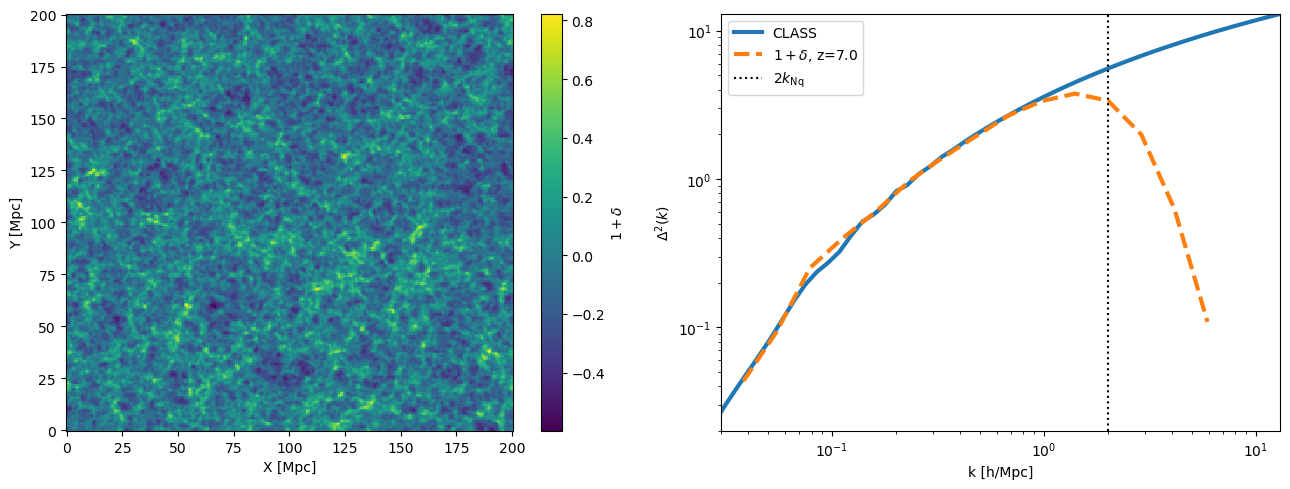

In [9]:
xx = np.linspace(0,box_len,matter_data.shape[0])
yy = np.linspace(0,box_len,matter_data.shape[1])

fig, axs = plt.subplots(1,2,figsize=(13,5))
c = axs[0].pcolor(xx, yy, np.log10(1+matter_data[:,:,10]), cmap='viridis')
fig.colorbar(c, ax=axs[0], label='$1+\delta$')
axs[0].set_xlabel('X [Mpc]')
axs[0].set_ylabel('Y [Mpc]')
axs[1].loglog(k_class, p_class*k_class**3/2/np.pi**2, ls='-', lw=3, label='CLASS')
axs[1].loglog(k_delta_m, p_delta_m*k_delta_m**3/2/np.pi**2/D(z)**2, ls='--', lw=3, label=f'$1+\delta$, z={z:.1f}')
axs[1].axvline(np.pi/2/box_len*matter_data.shape[0], ls=':', c='k', label='$2k_\mathrm{Nq}$')
axs[1].legend()
axs[1].set_xlabel('k [h/Mpc]')
axs[1].set_ylabel('$\Delta^2(k)$')
axs[1].axis([3e-2,13,2e-2,13])
plt.tight_layout()
plt.show()

### Halo catalogues -  200 Mpc/h 
The halo catalogue from the N-Body (pkdgrav3) snapshots will be downloaded.

In [10]:
hlc = GetData(name='pkdgrav3', work_dir=save_dir+'density/')

hl_url = 'https://ttt.astro.su.se/~sgiri/data/200Mpc/CDM_200Mpc_2048/haloes/'
file_list = hlc.set_link(data_url=hl_url, check_str='CDM_200Mpc_2048', ext='fof.txt')

Provided Data information:
Name     = pkdgrav3
check_str = CDM_200Mpc_2048
ext       = fof.txt
Total length of data list at the url: 120
Length of data list with CDM_200Mpc_2048: 120
Number of files found: 120
The first file: https://ttt.astro.su.se/~sgiri/data/200Mpc/CDM_200Mpc_2048/haloes//CDM_200Mpc_2048.00001.fof.txt


In [11]:
logdata = np.loadtxt(logfile)
logzs = -np.unique(-logdata[:,1])
logsn = np.arange(logzs.shape[0])
sn2zs = {si: zi for zi,si in zip(logzs,logsn)}

def sn2zs_func_halo(ff):
    si = int(ff.split('2048.')[-1].split('.fof')[0])
    return sn2zs[si]

zs_list = hlc.get_zlist(converter_func=sn2zs_func_halo)

The redshift of https://ttt.astro.su.se/~sgiri/data/200Mpc/CDM_200Mpc_2048/haloes//CDM_200Mpc_2048.00001.fof.txt is 89.03623


In [12]:
def read_pkdgrav3_halo_catalogue(filename):
    '''
    Each halo file contains Mass (Msun/h) and positions (X,Y,Z). 
    The position values range from -100 Mpc/h to 100 Mpc/h. 
    '''
    data = np.loadtxt(filename)
    return data
    
z = zs_list[np.abs(zs_list-z_ref).argmin()]
print(f'z={z}')

halo_data, halo_file = hlc.get_data_z(z, reader_func=read_pkdgrav3_halo_catalogue)
print(halo_data.shape)

z=7.005583
The file already exists.
(11060350, 4)


In [13]:
ht = np.histogram(np.log(halo_data[:,0]), bins=25, density=True)
dndlnm_nbody = ht[0]
mbins_nbody = np.exp(0.5*(ht[1][1:]+ht[1][:-1]))

We will compare the halo mass function from analytical extended Press-Schechter (EPS) calculation to the N-body.

In [14]:
par.code.kmin = 0.001
par.code.kmax = 200
par.code.Nk   = 100
par.code.NM   = 90
par.code.Nz   = 500
par.file.ps   = psfile
par.mf.window = 'smoothk'  # [sharpk,smoothk,tophat]
par.mf.dc = 1.686          # delta_c
par.mf.p  = 0.3             # p par of f(nu) [0.3,0.3,1] for [ST,smoothk,PS]
par.mf.q  = 1.0             # q par of f(nu) [0.707,1,1] for [ST,smoothk,PS]
par.mf.c  = 3.3
par.mf.beta = 4.8

ms, zs, dndlnm = toolscosmo.massfct.dndlnm(par)

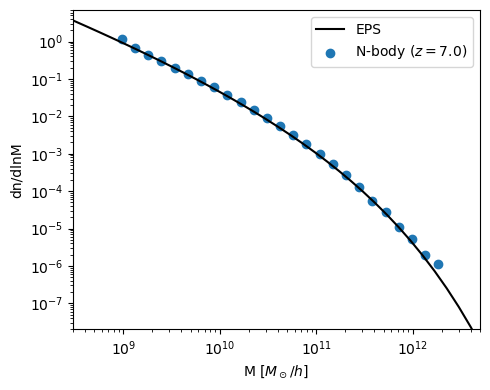

In [15]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.loglog(ms, dndlnm[np.abs(zs-z).argmin(),:], c='k', label='EPS')
ax.scatter(mbins_nbody, dndlnm_nbody, c='C0', label=f'N-body ($z={z:.1f}$)')
ax.axis([3e8,5e12,2e-8,7])
ax.legend()
ax.set_xlabel('M [$M_\odot/h$]')
ax.set_ylabel('dn/dlnM')
plt.tight_layout()
plt.show()

### 200Mpc Reionisation Simulation Suite
This simulation models the reionization process assuming spin saturation ($T_{S}\gg T_{CMB}$). is described in See [Giri et al. (2024)](https://arxiv.org/abs/2403.04838) the detailed description. 

In [16]:
def zs_func_xfrac(ff):
    return float(ff.split('xfrac_')[-1].split('.npy')[0])

def read_xfrac_files(filename):
    return np.load(filename)

### 200Mpc_Nion_4_Source1_SinkA

In [17]:
xfr_1A = GetData(name='pkdgrav3', work_dir=save_dir+'200Mpc_Nion_4_Source1_SinkA/')

xf_url = 'https://ttt.astro.su.se/~sgiri/data/200Mpc/200Mpc_Nion_4_Source1_SinkA/'
file_list = xfr_1A.set_link(data_url=xf_url, check_str='xfrac_', ext='npy')

zs_list = xfr_1A.get_zlist(converter_func=zs_func_xfrac)

Provided Data information:
Name     = pkdgrav3
check_str = xfrac_
ext       = npy
Total length of data list at the url: 176
Length of data list with xfrac_: 88
Number of files found: 88
The first file: https://ttt.astro.su.se/~sgiri/data/200Mpc/200Mpc_Nion_4_Source1_SinkA//xfrac_5.223.npy
The redshift of https://ttt.astro.su.se/~sgiri/data/200Mpc/200Mpc_Nion_4_Source1_SinkA//xfrac_5.223.npy is 5.223


In [18]:
z = zs_list[np.abs(zs_list-z_ref).argmin()]
print(f'z={z}')

xf_data_1A, xf_file_1A = xfr_1A.get_data_z(z, reader_func=read_xfrac_files)
print(xf_data_1A.shape)

dt_1A = t2c.mean_dt(z)*(1-xf_data_1A)*(1+matter_data)
p_dt_1A, k_dt_1A = t2c.power_spectrum_1d(dt_1A, box_dims=box_len, kbins=15)

z=7.006
The file already exists.
(256, 256, 256)


### 200Mpc_Nion_4_Source2_SinkA

In [19]:
xfr_2A = GetData(name='pkdgrav3', work_dir=save_dir+'200Mpc_Nion_4_Source2_SinkA/')

xf_url = 'https://ttt.astro.su.se/~sgiri/data/200Mpc/200Mpc_Nion_4_Source2_SinkA/'
file_list = xfr_2A.set_link(data_url=xf_url, check_str='xfrac_', ext='npy')

zs_list = xfr_2A.get_zlist(converter_func=zs_func_xfrac)

Provided Data information:
Name     = pkdgrav3
check_str = xfrac_
ext       = npy
Total length of data list at the url: 176
Length of data list with xfrac_: 88
Number of files found: 88
The first file: https://ttt.astro.su.se/~sgiri/data/200Mpc/200Mpc_Nion_4_Source2_SinkA//xfrac_5.223.npy
The redshift of https://ttt.astro.su.se/~sgiri/data/200Mpc/200Mpc_Nion_4_Source2_SinkA//xfrac_5.223.npy is 5.223


In [20]:
z = zs_list[np.abs(zs_list-z_ref).argmin()]
print(f'z={z}')

xf_data_2A, xf_file_2A = xfr_2A.get_data_z(z, reader_func=read_xfrac_files)
print(xf_data_2A.shape)

dt_2A = t2c.mean_dt(z)*(1-xf_data_2A)*(1+matter_data)
p_dt_2A, k_dt_2A = t2c.power_spectrum_1d(dt_2A, box_dims=box_len, kbins=15)

z=7.006
The file already exists.
(256, 256, 256)


### 200Mpc_Nion_4_Source3_SinkA

In [21]:
xfr_3A = GetData(name='pkdgrav3', work_dir=save_dir+'200Mpc_Nion_4_Source3_SinkA/')

xf_url = 'https://ttt.astro.su.se/~sgiri/data/200Mpc/200Mpc_Nion_4_Source3_SinkA/'
file_list = xfr_3A.set_link(data_url=xf_url, check_str='xfrac_', ext='npy')

zs_list = xfr_3A.get_zlist(converter_func=zs_func_xfrac)

Provided Data information:
Name     = pkdgrav3
check_str = xfrac_
ext       = npy
Total length of data list at the url: 170
Length of data list with xfrac_: 85
Number of files found: 85
The first file: https://ttt.astro.su.se/~sgiri/data/200Mpc/200Mpc_Nion_4_Source3_SinkA//xfrac_5.348.npy
The redshift of https://ttt.astro.su.se/~sgiri/data/200Mpc/200Mpc_Nion_4_Source3_SinkA//xfrac_5.348.npy is 5.348


In [22]:
z = zs_list[np.abs(zs_list-z_ref).argmin()]
print(f'z={z}')

xf_data_3A, xf_file_3A = xfr_3A.get_data_z(z, reader_func=read_xfrac_files)
print(xf_data_1A.shape)

dt_3A = t2c.mean_dt(z)*(1-xf_data_3A)*(1+matter_data)
p_dt_3A, k_dt_3A = t2c.power_spectrum_1d(dt_3A, box_dims=box_len, kbins=15)

z=7.006
The file already exists.
(256, 256, 256)


### 200Mpc_Nion_4_Source1_SinkB

In [23]:
xfr_1B = GetData(name='pkdgrav3', work_dir=save_dir+'200Mpc_Nion_4_Source1_SinkB/')

xf_url = 'https://ttt.astro.su.se/~sgiri/data/200Mpc/200Mpc_Nion_4_Source1_SinkB/'
file_list = xfr_1B.set_link(data_url=xf_url, check_str='xfrac_', ext='npy')

zs_list = xfr_1B.get_zlist(converter_func=zs_func_xfrac)

Provided Data information:
Name     = pkdgrav3
check_str = xfrac_
ext       = npy
Total length of data list at the url: 170
Length of data list with xfrac_: 85
Number of files found: 85
The first file: https://ttt.astro.su.se/~sgiri/data/200Mpc/200Mpc_Nion_4_Source1_SinkB//xfrac_5.348.npy
The redshift of https://ttt.astro.su.se/~sgiri/data/200Mpc/200Mpc_Nion_4_Source1_SinkB//xfrac_5.348.npy is 5.348


In [24]:
z = zs_list[np.abs(zs_list-z_ref).argmin()]
print(f'z={z}')

xf_data_1B, xf_file_1B = xfr_1B.get_data_z(z, reader_func=read_xfrac_files)
print(xf_data_1B.shape)

dt_1B = t2c.mean_dt(z)*(1-xf_data_1B)*(1+matter_data)
p_dt_1B, k_dt_1B = t2c.power_spectrum_1d(dt_1B, box_dims=box_len, kbins=15)

z=7.006
The file already exists.
(256, 256, 256)


### Compare Reionisation models

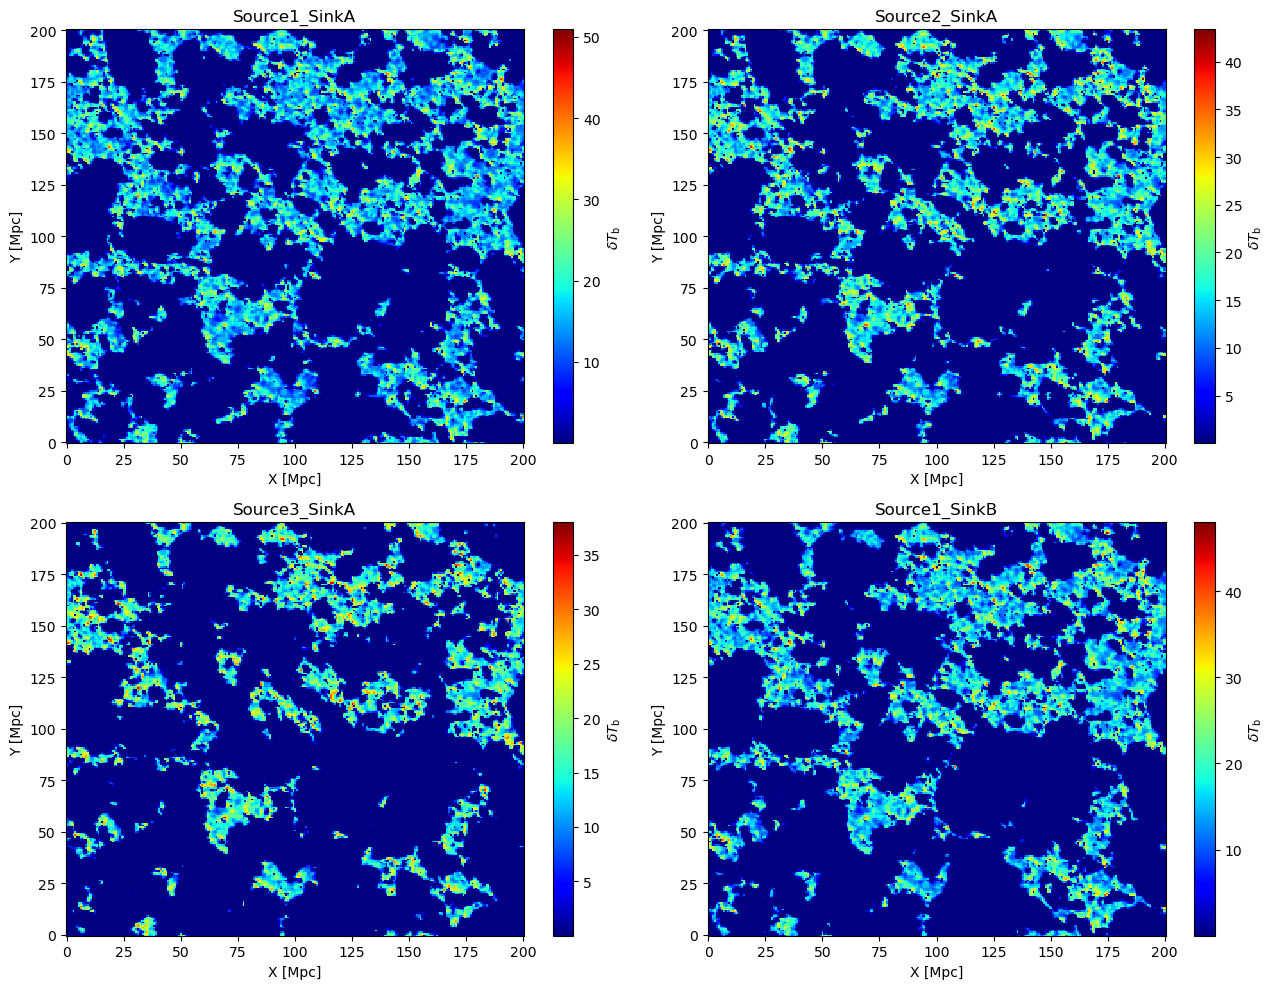

In [25]:
fig, axs = plt.subplots(2,2,figsize=(13,10))
axs[0,0].set_title('Source1_SinkA')
c = axs[0,0].pcolor(xx, yy, dt_1A[:,:,10], cmap='jet')
fig.colorbar(c, ax=axs[0,0], label=r'$\delta T_\mathrm{b}$')
axs[0,1].set_title('Source2_SinkA')
c = axs[0,1].pcolor(xx, yy, dt_2A[:,:,10], cmap='jet')
fig.colorbar(c, ax=axs[0,1], label=r'$\delta T_\mathrm{b}$')
axs[1,0].set_title('Source3_SinkA')
c = axs[1,0].pcolor(xx, yy, dt_3A[:,:,10], cmap='jet')
fig.colorbar(c, ax=axs[1,0], label=r'$\delta T_\mathrm{b}$')
axs[1,1].set_title('Source1_SinkB')
c = axs[1,1].pcolor(xx, yy, dt_1B[:,:,10], cmap='jet')
fig.colorbar(c, ax=axs[1,1], label=r'$\delta T_\mathrm{b}$')
for ax in axs.flatten():
    ax.set_xlabel('X [Mpc]')
    ax.set_ylabel('Y [Mpc]')
plt.tight_layout()
plt.show()

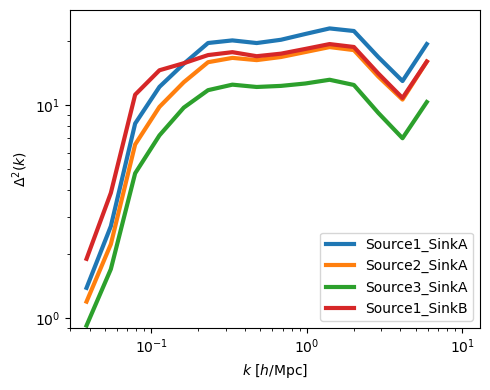

In [26]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.loglog(k_dt_1A, p_dt_1A*k_dt_1A**3/2/np.pi**2, ls='-', lw=3, label='Source1_SinkA')
ax.loglog(k_dt_2A, p_dt_2A*k_dt_2A**3/2/np.pi**2, ls='-', lw=3, label='Source2_SinkA')
ax.loglog(k_dt_3A, p_dt_3A*k_dt_3A**3/2/np.pi**2, ls='-', lw=3, label='Source3_SinkA')
ax.loglog(k_dt_1B, p_dt_1B*k_dt_1B**3/2/np.pi**2, ls='-', lw=3, label='Source1_SinkB')
ax.axis([3e-2,13,9e-1,28])
ax.legend()
ax.set_xlabel('$k$ [$h$/Mpc]')
ax.set_ylabel('$\Delta^2(k)$')
plt.tight_layout()
plt.show()